<a href="https://colab.research.google.com/github/satani99/fastai_22_2/blob/main/Convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!git clone https://github.com/fastai/course22p2.git

Cloning into 'course22p2'...
remote: Enumerating objects: 1176, done.
remote: Counting objects: 100% (1176/1176), done.
remote: Compressing objects: 100% (480/480), done.
remote: Total 1176 (delta 712), reused 1117 (delta 694), pack-reused 0
Receiving objects: 100% (1176/1176), 99.81 MiB | 26.28 MiB/s, done.
Resolving deltas: 100% (712/712), done.


In [10]:
%cd course22p2

/content/course22p2


In [18]:
!wget https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz

--2023-08-18 12:05:24--  https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz [following]
--2023-08-18 12:05:24--  https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17051982 (16M) [application/octet-stream]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  16.26M  --.-KB/s    in 0.1s    

2023-08-18 12:05:25 (135 MB/s) - 

In [13]:
import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

from miniai.training import *
from miniai.datasets import *

In [15]:
import pickle, gzip, math, os, time, shutil, torch, matplotlib as mpl, numpy as np
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor

from torch.utils.data import DataLoader
from typing import Mapping

In [16]:
mpl.rcParams['image.cmap'] = 'gray'

In [21]:
path_data = Path('./')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])


In [22]:
x_imgs = x_train.view(-1, 28, 28)
xv_imgs = x_valid.view(-1, 28, 28)

In [23]:
mpl.rcParams['figure.dpi'] = 30

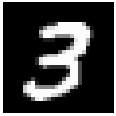

In [25]:
im3 = x_imgs[7]
show_image(im3);

In [26]:
top_edge = tensor([[-1, -1, -1],
                   [0, 0, 0],
                   [1, 1, 1]]).float()

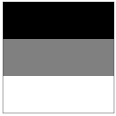

In [27]:
show_image(top_edge, noframe=False);

In [29]:
df = pd.DataFrame(im3[:13, :23])
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


In [30]:
(im3[3:6, 14:17] * top_edge).sum()

tensor(2.9727)

In [31]:
(im3[7:10, 14:17] * top_edge).sum()

tensor(-2.9570)

In [32]:
def apply_kernel(row, col, kernel): return (im3[row-1:row+2, col-1:col+2] * kernel).sum()

In [33]:
apply_kernel(4, 15, top_edge)

tensor(2.9727)

In [34]:
[[(i, j) for j in range(5)] for i in range(5)]

[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)],
 [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]]

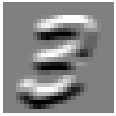

In [35]:
rng = range(1, 27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])
show_image(top_edge3);

In [36]:
left_edge = tensor([[-1, 0, 1],
                    [-1, 0, 1],
                    [-1, 0, 1]]).float()

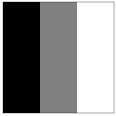

In [37]:
show_image(left_edge, noframe=False);

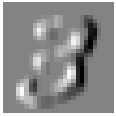

In [38]:
left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
show_image(left_edge3);

In [39]:
import torch.nn.functional as F
import torch

In [43]:
inp = im3[None, None, :, :].float()
print(inp.shape)
inp_unf = F.unfold(inp, (3, 3))[0]
inp_unf.shape

torch.Size([1, 1, 28, 28])


torch.Size([9, 676])

In [42]:
w = left_edge.view(-1)
w.shape

torch.Size([9])

In [45]:
out_unf = w@inp_unf
out_unf.shape

torch.Size([676])

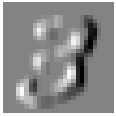

In [46]:
out = out_unf.view(26, 26)
show_image(out);

In [47]:
%timeit -n 1 tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng]);

19 ms ± 4.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%timeit -n 100 (w@F.unfold(inp, (3,3))[0]).view(26, 26);

110 µs ± 27.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
%timeit -n 100 F.conv2d(inp, left_edge[None, None])

The slowest run took 11.23 times longer than the fastest. This could mean that an intermediate result is being cached.
38.6 µs ± 55.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
diag1_edge = tensor([[0, -1, 1],
                     [-1, 1, 0],
                     [1, 0, 0]]).float()

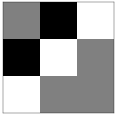

In [54]:
show_image(diag1_edge, noframe=False);

In [56]:
diag2_edge = tensor([[1, -1, 0],
                     [0, 1, -1],
                     [0, 0, 1]]).float()

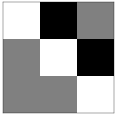

In [57]:
show_image(diag2_edge, noframe=False);

In [58]:
xb = x_imgs[:16][:,None]
xb.shape

torch.Size([16, 1, 28, 28])

In [59]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:, None]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [60]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])